In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Matrix Capsules with EM Routing
This notebook covers the fundamental components introduced in this paper. The routing procedure is covered from the bottom up. This will serve as a starting point to implementing the complete solution.

In [41]:
def cost_function(beta_u, sigma_j, R_j_sum):
    """Computes the cost of all h dimensions."""
    return (beta_u + torch.log(sigma_j)) * R_j_sum

def activation(lam, beta_a, cost):
    """Activation function for a capsule j."""
    return torch.sigmoid(lam * (beta_a - cost.sum()))

## Activation Function
What does the activation function look like? Under what circumstances is a capsule activated?

`beta_a` represents the cost to describe the high-level capsule.
`lam` is an inverse temperature parameter.

<IPython.core.display.Javascript object>


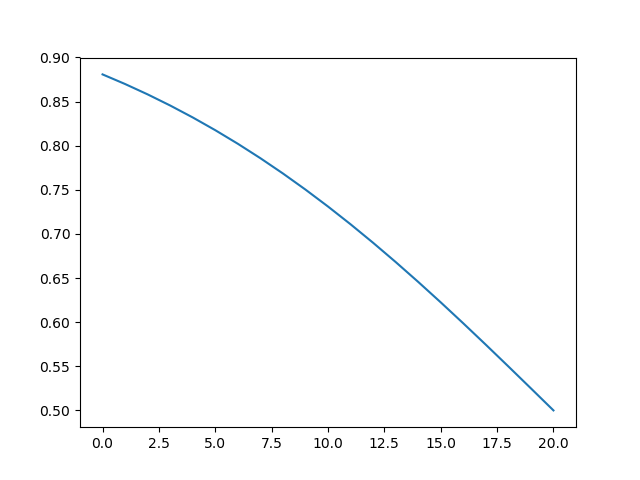

In [56]:
cost = torch.Tensor(np.linspace(-1, 1, 21))
beta_a = 1
lam = 1
r = []
for i in range(cost.shape[0]):
    r.append(activation(lam, beta_a, cost[i]))
    
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(r)
fig.show()

With lambda and beta_a fixed, increasing the cost reduces the activation output.
Increasing the description length `beta_a` increases the activation output.
Increasing `lam` changes the shape of the curve.

## M-Step

Imagine there are 3 capsules in layer `i` and 2 capsules in layer `j`. Two of the low-level capsules represent some feature on a face: the eyes and nose. The third low-level capsule will represent a finger. Let the 2 capsules in layer `j` repesent the face and hand.

We will assume that we have strong activations from capsules `i=1` and `i=2` which indicates, intuitively, that there may be a face. To start this example, we need to represent the capsules.

In [61]:
votes_i = torch.randn(3, 2, 16)
activations_i = torch.Tensor([0.9, 0.9, 0.1])
R = torch.Tensor([[0.9, 0.1],
                 [0.9, 0.1],
                 [0.1, 0.9]])
beta_u = 1

# Scale the responsibility matrix by the activations of the capsules in layer i
R = activations_i.repeat(2, 1).transpose(0, 1) * R

mean_j = torch.zeros(2, 16)
sigma_j = torch.zeros(2, 16)
cost_j = torch.zeros(2, 16)
activations_j = torch.zeros(2)

# Calculate the mean and variance for each dimension
for j in range(votes_i.shape[1]):  # Iterate over higher-level capsules
    R_sum_j = R.sum(0)[j]
    for h in range(mean_j.shape[1]):
        vote_sum_h = torch.dot(R[:, j], votes_i[:, j, h])
        mean_j[j, h] = vote_sum_h / R_sum_j
        
    # Variance
    for h in range(sigma_j.shape[1]):
        sigma_j[j, h] = torch.dot(R[:, j], (votes_i[:, j, h] - mean_j[j, h])**2)
        
    # Compute the h costs
    cost_j[j] = cost_function(beta_u, sigma_j[j], R_sum_j)
    
    # Compute the high-level activations
    activations_j[j] = activation(lam, beta_a, cost_j[j])
    
print(cost_j)
print(activations_j)

tensor([[ 3.3540, -0.3084,  2.4924,  1.6808,  1.3299,  0.8231,  1.2318, -0.5552,
         -1.6054,  2.3445,  1.1024,  3.2077,  0.3061, -0.2098, -2.1299,  4.1516],
        [-0.0623, -0.6625,  0.1949, -0.2817, -0.6058, -0.6233, -0.9419,  0.0201,
         -0.4182, -0.1485, -0.5556,  0.3164, -0.3028,  0.0885, -0.4597, -0.1242]])
tensor([9.0710e-08, 9.9619e-01])
